# Dataset Split

Split dataset into test, validation and training set.

An important point to make about the preprocessing is that
any preprocessing statistics (e.g. the data mean)
must only be computed on the training data.
(https://cs231n.github.io/neural-networks-2/)

The data is imbalanced.
Use http://contrib.scikit-learn.org/imbalanced-learn/index.html.

In [1]:
%matplotlib inline

In [2]:
import h5py
import numpy as np
import sklearn.utils
from sklearn.model_selection import train_test_split
import imblearn.over_sampling
import matplotlib.pyplot as plt

In [3]:
f = h5py.File('data/data.hdf5')
X = f['X'][...]
y = f['y'][...]

In [4]:
labels, counts = np.unique(y, return_counts=True)
for label, count in zip(labels, counts):
    print('label {}: {} samples'.format(label, count))

label 0: 5301 samples
label 1: 6103 samples
label 3: 1533 samples


In [5]:
N_LABELS = 3

## Balancing Training Set

https://arxiv.org/pdf/1609.06570v1.pdf

In [6]:
X_bal, y_bal = X[...], y[...]
# call four times because each time only one class is balanced
smote = imblearn.over_sampling.SMOTE()
for i in range(N_LABELS - 1):
    X_bal, y_bal = smote.fit_sample(X_bal, y_bal)

np.unique(y, return_counts=True), np.unique(y_bal, return_counts=True)

/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


((array([0, 1, 3]), array([5301, 6103, 1533])),
 (array([0, 1, 3]), array([6103, 6103, 6103])))

In [7]:
X_tr, X_te, y_tr, y_te = train_test_split(X_bal, y_bal, test_size=0.1, stratify=y_bal)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.1, stratify=y_tr)
np.unique(y_tr, return_counts=True), np.unique(y_val, return_counts=True), np.unique(y_te, return_counts=True)

((array([0, 1, 3]), array([4943, 4944, 4943])),
 (array([0, 1, 3]), array([549, 549, 550])),
 (array([0, 1, 3]), array([611, 610, 610])))

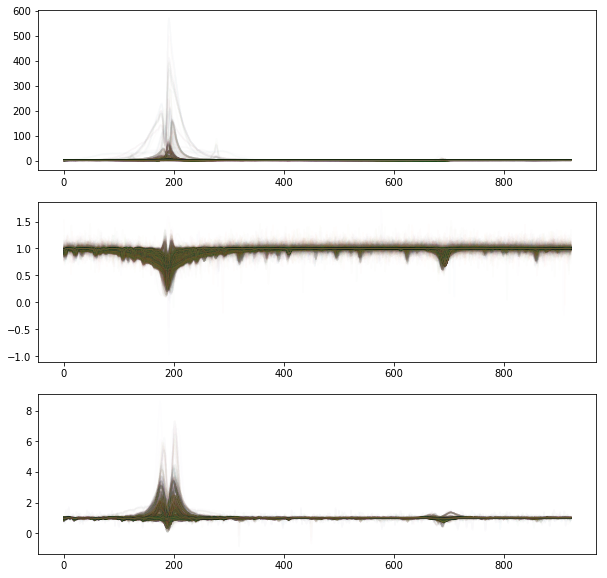

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for label, ax in zip([0, 1, 3], axs):
    idxs = y_bal == label
    for x in X_bal[idxs]:
        ax.plot(x, alpha=0.01)

In [9]:
try:
    del f['X_tr']
    del f['X_val']
    del f['X_te']
    del f['y_tr']
    del f['y_val']
    del f['y_te']
except:
    pass
    
f.create_dataset('X_tr', X_tr.shape, dtype=np.float32)[...] = X_tr
f.create_dataset('X_val', X_val.shape, dtype=np.float32)[...] = X_val
f.create_dataset('X_te', X_te.shape, dtype=np.float32)[...] = X_te

f.create_dataset('y_tr', y_tr.shape, dtype=np.int)[...] = y_tr
f.create_dataset('y_val', y_val.shape, dtype=np.int)[...] = y_val
f.create_dataset('y_te', y_te.shape, dtype=np.int)[...] = y_te

In [10]:
f.close()